# 1. Make classification data

In [1]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


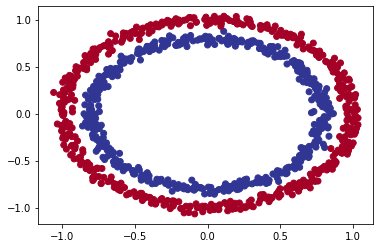

In [4]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [5]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [6]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [7]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Create model

In [67]:
import torch.nn.functional as F

class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=32)
        self.layer2 = nn.Linear(in_features=32, out_features=32)
        self.layer3 = nn.Linear(in_features=32, out_features=1)
        #self.relu = nn.ReLU()
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [68]:
model_1 = CircleModel().to(device)
print(model_1)

CircleModel(
  (layer1): Linear(in_features=2, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
)


In [69]:
next(model_1.parameters()).device

device(type='cuda', index=0)

PyTorch has two binary cross entropy implementations:

1. torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).

2. torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).
Which one should you use?

The documentation for torch.nn.BCEWithLogitsLoss() states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of nn.Sigmoid and torch.nn.BCELoss() but that is beyond the scope of this notebook.

In [70]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)


In [71]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# 3. Train model

## Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

Before we the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the forward() method).

To do so, let's pass the model some data.


In [72]:
y_logits = model_1(X_test.to(device))[:5]
y_logits

tensor([[ 0.0132],
        [ 0.0240],
        [-0.0008],
        [ 0.0088],
        [-0.0304]], device='cuda:0', grad_fn=<SliceBackward0>)

Since our model hasn't been trained, these outputs are basically random.

But what are they?

They're the output of our forward() method.


The raw outputs (unmodified) of this equation () and in turn, the raw outputs of our model are often referred to as logits.

That's what our model is outputing above when it takes in the input data ( in the equation or X_test in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

Let's try it out.

In [73]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5033],
        [0.5060],
        [0.4998],
        [0.5022],
        [0.4924]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [74]:
# so in full
y_preds = torch.round(torch.sigmoid(model_1(X_test.to(device))[:5]))
# Get rid of extra dimension to compare with y_test
y_preds.squeeze()

tensor([1., 1., 0., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [75]:
y_test[:5]

tensor([1., 0., 1., 0., 1.], device='cuda:0')

In [76]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = criterion(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = criterion(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69472, Accuracy: 46.88% | Test Loss: 0.69439, Test Accuracy: 47.00%
Epoch: 100 | Loss: 0.68960, Accuracy: 58.13% | Test Loss: 0.68960, Test Accuracy: 58.50%
Epoch: 200 | Loss: 0.68380, Accuracy: 66.00% | Test Loss: 0.68441, Test Accuracy: 64.50%
Epoch: 300 | Loss: 0.67430, Accuracy: 73.12% | Test Loss: 0.67620, Test Accuracy: 77.50%
Epoch: 400 | Loss: 0.65538, Accuracy: 81.38% | Test Loss: 0.65951, Test Accuracy: 81.50%
Epoch: 500 | Loss: 0.61523, Accuracy: 94.75% | Test Loss: 0.62432, Test Accuracy: 91.50%
Epoch: 600 | Loss: 0.52980, Accuracy: 99.50% | Test Loss: 0.54699, Test Accuracy: 99.00%
Epoch: 700 | Loss: 0.37715, Accuracy: 99.75% | Test Loss: 0.40581, Test Accuracy: 99.00%
Epoch: 800 | Loss: 0.21716, Accuracy: 99.88% | Test Loss: 0.25378, Test Accuracy: 99.50%
Epoch: 900 | Loss: 0.12080, Accuracy: 99.88% | Test Loss: 0.15610, Test Accuracy: 99.50%


In [77]:
# Make predictions
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [78]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

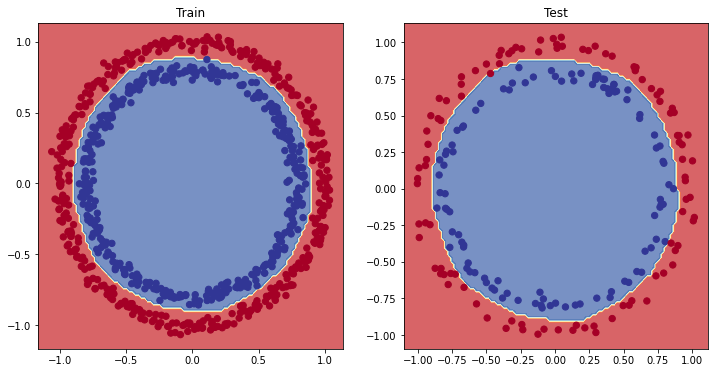

In [79]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test) # model_3 = has non-linearity

# 4. Multiclass classification

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


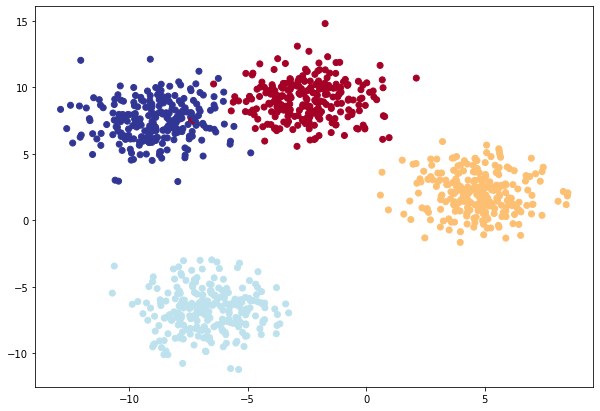

In [80]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [81]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [82]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=32):
        super().__init__()
        self.linear1 = nn.Linear(in_features=input_features, out_features=hidden_units)
        self.linear2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.linear3 = nn.Linear(in_features=hidden_units, out_features=output_features)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [83]:
model2 = BlobModel(NUM_FEATURES, NUM_CLASSES).to(device)
model2

BlobModel(
  (linear1): Linear(in_features=2, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=4, bias=True)
)

In [84]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

## Getting prediction probabilities for a multi-class PyTorch model

In [85]:
model2(X_blob_train.to(device))[:5]

tensor([[ 0.2606, -0.1137,  0.3300, -0.0421],
        [ 0.2615,  0.9234,  0.6179, -0.6539],
        [-0.2194,  0.0032, -0.1279,  0.1643],
        [-0.1789,  0.0867,  0.0422,  0.0069],
        [ 0.2312,  0.8141,  0.3878, -0.4445]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [87]:
# How many elements in a single prediction sample?
model2(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

Wonderful, our model is predicting one value for each class that we have.

Do you remember what the raw outputs of our model are called?

Hint: it rhymes with "frog splits" (no animals were harmed in the creation of these materials).

If you guessed logits, you'd be correct.

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from logits -> prediction probabilities -> prediction labels just like we did with the binary classification problem?

That's where the softmax activation function comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

If this doesn't make sense, let's see in code.

In [90]:
y_logits = model2(X_blob_train.to(device))[:5]
y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits)
print(y_pred_probs)

tensor([[ 0.2606, -0.1137,  0.3300, -0.0421],
        [ 0.2615,  0.9234,  0.6179, -0.6539],
        [-0.2194,  0.0032, -0.1279,  0.1643],
        [-0.1789,  0.0867,  0.0422,  0.0069],
        [ 0.2312,  0.8141,  0.3878, -0.4445]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2859, 0.1966, 0.3064, 0.2112],
        [0.2098, 0.4067, 0.2996, 0.0840],
        [0.2078, 0.2596, 0.2277, 0.3050],
        [0.2103, 0.2742, 0.2623, 0.2532],
        [0.2237, 0.4007, 0.2617, 0.1138]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [93]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

These prediction probablities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using torch.argmax().

In [103]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2859, 0.1966, 0.3064, 0.2112], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(2, device='cuda:0')


## Training the model

In [104]:
torch.manual_seed(42)

epochs = 100

X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model2.train()
    
    train_logits = model2(X_blob_train)
    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)
    loss = criterion(train_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, train_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model2.eval()
    
    with torch.inference_mode():
        test_logits = model2(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = criterion(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_preds)
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.73760, Acc: 1.50% | Test Loss: 1.00629, Test Acc: 80.50%
Epoch: 10 | Loss: 0.18628, Acc: 97.00% | Test Loss: 0.17631, Test Acc: 96.50%
Epoch: 20 | Loss: 0.07569, Acc: 99.12% | Test Loss: 0.06696, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05480, Acc: 99.12% | Test Loss: 0.04708, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04542, Acc: 99.12% | Test Loss: 0.03776, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04017, Acc: 99.12% | Test Loss: 0.03234, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03685, Acc: 99.12% | Test Loss: 0.02882, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03458, Acc: 99.12% | Test Loss: 0.02633, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03293, Acc: 99.12% | Test Loss: 0.02449, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03169, Acc: 99.12% | Test Loss: 0.02306, Test Acc: 99.50%


In [106]:
# Make predictions
model2.eval()
with torch.inference_mode():
    y_logits = model2(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 0.7463,  7.2719, -2.0038, -3.3629],
        [ 0.7006, -2.8213, -0.8367,  6.7919],
        [-3.5064, -2.7624,  6.4969, -1.0327],
        [-0.7889,  5.6616, -1.3043, -1.8632],
        [ 7.3239,  1.8833, -3.2894, -1.1102],
        [ 0.4095, -3.3859, -0.8124,  8.3342],
        [-3.1042, -2.0669,  5.5604, -1.3653],
        [ 6.9603, -0.2257, -2.9908,  0.4886],
        [-4.7352, -3.4954,  7.8817, -0.5408],
        [ 7.0458,  0.4503, -3.0373, -0.0663]], device='cuda:0')

In [107]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


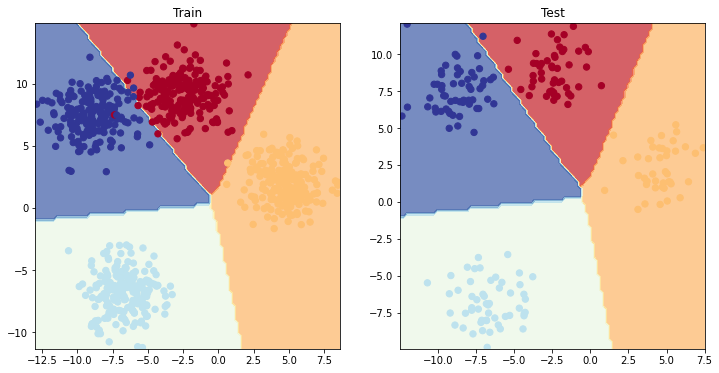

In [109]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model2, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, X_blob_test, y_blob_test)

In [110]:
!pip -q install torchmetrics

In [111]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy().to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

2022-11-19 09:03:32.895177: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:
2022-11-19 09:03:32.895246: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


tensor(0.9950, device='cuda:0')